In [62]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import statistics
from fund.fund import Fund
from fund.states import States

In [63]:
market = Market()
save_parameters = True
fund = Fund("delta",States.BACKTEST)
fund.pull_portfolios()
fund.initialize_portfolios()

In [64]:
market.connect()
sp5 = market.retrieve("sp500")
market.disconnect()

In [140]:
startDate = datetime(2016,1,1)
endDate = datetime(2022,1,1)
starting_capital = 100000
positions = 10
trades = fund.pull_trades()
portfolios = fund.pull_portfolio_states()

In [141]:
pt = pd.concat(portfolios)

In [142]:
pt["positions"] = [pickle.loads(x) for x in pt["positions"]]

In [143]:
t = pd.concat(trades)

In [144]:
non_params = ["date","sell_date","ticker","adjclose","sell_price","delta","projected_delta","position","holding",'close',
 'high',
 'low',
 'open',
 'volume',
 'adjhigh',
 'adjlow',
 'adjopen',
 'adjvolume',
 'divcash',
 'splitfactor',
 'year',
 'week',
 'quarter',
 'prediction',
"buy_price","amount","pv",
"swap"]
parameter_columns = [x for x in t.columns if x not in non_params]

In [145]:
t["holding"] = [(row[1]["sell_date"] - row[1]["date"]).days for row in t.iterrows()]

In [146]:
parameter_columns

['signal', 'req', 'value', 'oc', 'strategy']

In [147]:
iterations = t.groupby(parameter_columns).mean().reset_index()[parameter_columns]

In [148]:
iterations

,signal,req,value,oc,strategy
0,0.05,0.05,True,False,financial
1,0.05,0.15,True,False,financial
2,0.05,0.30,True,False,financial
3,0.15,0.05,True,False,financial
4,0.15,0.15,True,False,financial
5,0.15,0.30,True,False,financial
6,0.30,0.05,True,False,financial
7,0.30,0.15,True,False,financial


In [167]:
analysis = []
for row in iterations.iterrows():
    iteration_trades = t.copy()
    for col in iterations.columns:
        param = row[1][col]
        iteration_trades = iteration_trades[(iteration_trades[col]==param)]
    for position in range(positions):
        try:
            position_trades = iteration_trades[(iteration_trades["position"]==position) & (iteration_trades["sell_date"]>startDate) & (iteration_trades["sell_date"]<endDate)]
            initial = 100 / positions
            for delta in position_trades["delta"]:
                initial = initial * (1+delta)
            analysis_record = {
                "position":position,
                "holding":position_trades["holding"].mean(),
                "pv":initial
            }
            for col in iterations.columns:
                analysis_record[col] = row[1][col]
            analysis.append(analysis_record)
        except Exception as e:
            print(str(e))
            continue
a = pd.DataFrame(analysis)

In [168]:
metric = "pv"
complete = a.pivot_table(index=parameter_columns,columns="position",values=metric).reset_index()
included_positions = max([int(x) for x in complete.columns if x not in parameter_columns])
if metric == "variance":
    ascending=True
    complete.fillna(1,inplace=True)
    complete[metric] = [sum([row[1][i] for i in range(included_positions) if row[1][i] != 1])/len([x for x in range(positions) if row[1][x] != 1]) for row in complete.iterrows()]
else:
    ascending = False
    bitcoin_strats = complete[(complete["strategy"]=="bitcoin_speculation") | (complete["strategy"]=="bitcoin_brute")].fillna(0)
    stock_strats = complete[(complete["strategy"]!="bitcoin_speculation") & (complete["strategy"]!="bitcoin_brute")].fillna(0)
    complete = pd.concat([bitcoin_strats,stock_strats])
    complete[metric] = [sum([row[1][i] for i in range(included_positions+1)]) for row in complete.iterrows()]
complete.sort_values(metric,ascending=False).head(20)

position,signal,req,value,oc,strategy,0,1,2,3,4,5,6,7,8,9,pv
2,0.05,0.30,True,False,financial,3.981188,63.132339,11.601977,48.624877,115.438881,14.653018,7.007282,27.816359,4.924057,27.108503,324.288481
5,0.15,0.30,True,False,financial,3.612935,57.531202,8.606111,30.134206,59.126311,6.348606,12.260421,12.313058,14.073975,8.081975,212.088801
1,0.05,0.15,True,False,financial,3.034978,23.741633,16.528539,45.891161,33.668656,10.554628,2.457026,22.082870,2.938891,18.628688,179.527071
4,0.15,0.15,True,False,financial,2.989186,35.220985,6.997976,32.352056,25.485855,7.470405,13.885636,10.627494,13.214707,5.069641,153.313942
7,0.30,0.15,True,False,financial,3.901686,12.862278,11.779024,11.946599,9.352828,9.912641,11.500000,11.500000,10.000000,10.000000,102.755057
0,0.05,0.05,True,False,financial,3.980869,4.576566,7.200157,11.169241,13.959829,14.971488,5.957850,3.458320,3.407196,30.663248,99.344765
3,0.15,0.05,True,False,financial,3.791303,14.293182,4.275316,4.421960,11.781947,11.475313,11.436872,5.421985,4.027997,23.117873,94.043749
6,0.30,0.05,True,False,financial,1.690013,2.848609,11.593779,9.729421,5.876368,14.158443,3.662125,3.227027,7.020776,10.042879,69.849440


In [169]:
results = []
for strategy in complete["strategy"].unique():
    results.append(complete[complete["strategy"]==strategy].sort_values("pv",ascending=False).head(1))
backtest_report = pd.concat(results)
backtest_report

position,signal,req,value,oc,strategy,0,1,2,3,4,5,6,7,8,9,pv
2,0.05,0.3,True,False,financial,3.981188,63.132339,11.601977,48.624877,115.438881,14.653018,7.007282,27.816359,4.924057,27.108503,324.288481


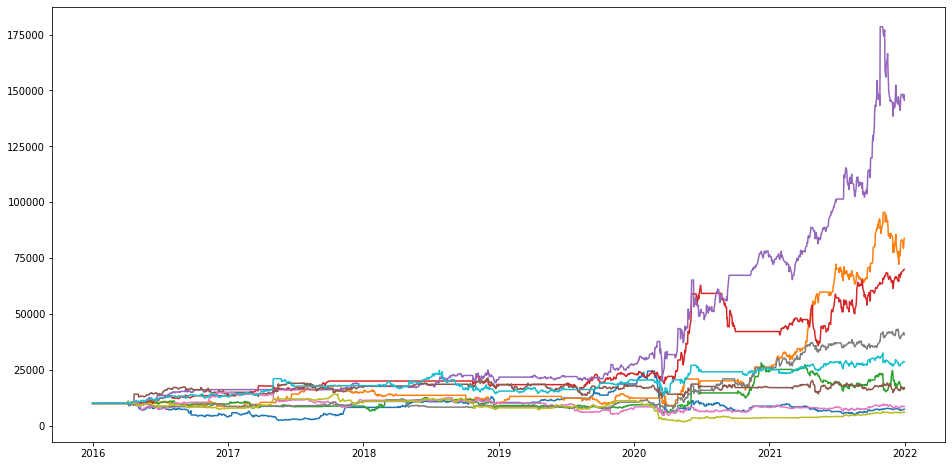

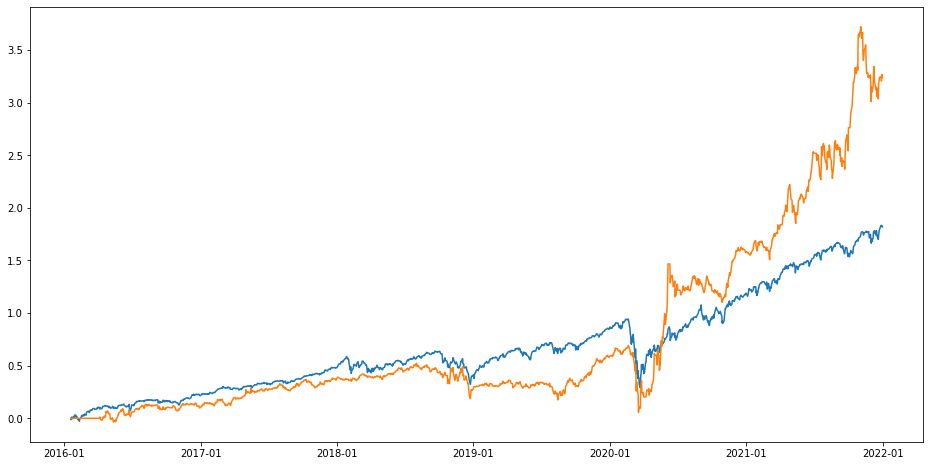

In [170]:
positions = 10
for strategy in complete["strategy"].unique():
    best_it = backtest_report[backtest_report["strategy"]==strategy].copy()
    portfolios = pt.copy()
    for col in iterations.columns:
        portfolios = portfolios[portfolios[col]==best_it[col].item()]
    visualizations = []
    for row in portfolios.iterrows():
        portfolio = row[1]
        position_states = []
        for position in portfolio["positions"].keys():
            current_date = portfolio["date"]
            position_dictionary = portfolio["positions"][position]
            state = {"date":current_date,"position":position,"cash":position_dictionary["cash"]}
            asset = position_dictionary["asset"]
            if  asset != {}:
                state["asset_pv"] = asset["pv"]
            else:
                state["asset_pv"] = 0
            position_states.append(state)
        final = pd.DataFrame(position_states)
        final["pv"] = final["cash"] + final["asset_pv"]
        visualization = final.pivot_table(index="date",columns="position",values="pv").reset_index()
        visualizations.append(visualization)
    report = pd.concat(visualizations)
    if positions == 1:
        report["pv"] = report[0]
    else:
        report["pv"] = [sum([row[1][i] for i in range(0,positions)]) for row in report.iterrows()]
    report.reset_index(inplace=True)
    figure, axes = plt.subplots(figsize=(16, 8))
    for i in range(0,positions):
        axes.plot(report["date"],report[i])
    plt.show()
    if strategy == "bitcoin_speculation" or strategy == "bitcoin_brute":
        bench = price_data.copy()
        close_col = "adjclose"
    else:
        bench = pd.read_csv("./csv_files/FED/SPY.csv")
        bench = p.column_date_processing(bench)
        close_col = "adjclose"   
    ds = bench[(bench["date"]<=endDate) &(bench["date"]>=startDate)].merge(report.rename(columns={"sell_date":"date"}),on="date",how="left").sort_values("date")
    ds = ds.fillna(method="ffill").fillna(starting_capital/positions).iloc[10:]
    ds["bench_prog"] = (ds[close_col] - ds[close_col].iloc[0]) / ds[close_col].iloc[0]
    ds["portfolio_prog"] = (ds["pv"] - starting_capital) / starting_capital
    ds["portfolio_deriv"] = ds["portfolio_prog"].pct_change()
    ds["bench_deriv"] = ds["bench_prog"].pct_change()
    figure, axes = plt.subplots(figsize=(16, 8))
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes.plot(ds["date"],
             ds["bench_prog"])
    axes.plot(ds["date"],
             ds["portfolio_prog"])
    plt.show()

In [171]:
ds

,date,open,high,low,close,adjclose,volume,year,quarter,week,...,5,6,7,8,9,pv,bench_prog,portfolio_prog,portfolio_deriv,bench_deriv
10,2016-01-19,189.960007,190.110001,186.199997,188.059998,167.978836,195244400,2016,1,3,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,100000.000000,0.000000,0.000000,NaN,NaN
11,2016-01-20,185.029999,187.500000,181.020004,185.649994,165.826202,286547800,2016,1,3,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,100000.000000,-0.012815,0.000000,NaN,-inf
12,2016-01-21,186.210007,188.869995,184.639999,186.690002,166.755157,195772900,2016,1,3,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,100000.000000,-0.007285,0.000000,NaN,-0.431543
13,2016-01-22,189.779999,190.759995,188.880005,190.520004,170.176132,168319600,2016,1,3,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,100000.000000,0.013081,0.000000,NaN,-2.795647
14,2016-01-25,189.919998,190.149994,187.410004,187.639999,167.603653,130371700,2016,1,4,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,100000.000000,-0.002234,0.000000,NaN,-1.170748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,2021-12-27,472.059998,477.309998,472.010010,477.260010,475.781921,56808600,2021,4,52,...,17053.226104,8657.570722,40901.134528,6064.639175,28415.517708,424600.049366,1.832392,3.246000,0.001724,0.022046
1507,2021-12-28,477.720001,478.809998,476.059998,476.869995,475.393127,47274600,2021,4,52,...,16835.946104,8607.410722,41137.294528,6028.239175,28601.157708,420617.907194,1.830078,3.206179,-0.012268,-0.001263
1508,2021-12-29,476.980011,478.559998,475.920013,477.480011,476.001251,54503000,2021,4,52,...,16548.826104,8502.530722,41701.774528,6085.989175,28686.697708,421181.837622,1.833698,3.211818,0.001759,0.001978
1509,2021-12-30,477.929993,479.000000,475.670013,476.160004,474.685333,55329000,2021,4,52,...,16775.806104,8614.250722,41396.494528,6077.239175,28531.997708,426749.584288,1.825864,3.267496,0.017335,-0.004272


In [172]:
industry_report = []
stock_report = []
for strategy in complete["strategy"].unique():
    best_it = complete[complete["strategy"]==strategy].sort_values(metric,ascending=False).iloc[0]
    best_trades = t.copy()
    for col in parameter_columns:
        best_trades = best_trades[best_trades[col]==best_it[col]]
    best_trades = best_trades[(best_trades["sell_date"]>=startDate) & (best_trades["sell_date"]<=endDate)]
    reporting = best_trades.merge(sp5.rename(columns={"Symbol":"ticker"}),on="ticker",how="left").sort_values("delta",ascending=False)[["date","sell_date","position","holding","projected_delta","value","delta","ticker","Security","GICS Sector","sell_price","buy_price"]]
    reporting["strategy"] = strategy
    stock_report.append(reporting.sort_values("delta",ascending=False))
    reporting["delta"] = reporting["delta"] + 1
    ir = reporting.groupby(["GICS Sector"]).agg({"delta":np.prod,"buy_price":"mean","projected_delta":"mean","holding":"mean"}).sort_values("delta",ascending=False)
    ir["strategy"] = strategy
    industry_report.append(ir)    

In [173]:
stock_trades = pd.concat(stock_report).sort_values("date",ascending=True)
stock_trades.head(10)

,date,sell_date,position,holding,projected_delta,value,delta,ticker,Security,GICS Sector,sell_price,buy_price,strategy
0,2016-04-05,2016-04-22,5,17,0.141231,True,0.300000,AMD,AMD,Information Technology,3.679000,2.830000,financial
4,2016-04-05,2016-07-01,2,87,0.175197,True,0.058767,VRTX,Vertex Pharmaceuticals,Health Care,87.740000,82.870000,financial
9,2016-04-05,2016-07-01,8,87,0.089928,True,-0.115470,REGN,Regeneron,Health Care,358.500000,405.300000,financial
8,2016-04-05,2016-07-01,7,87,0.096417,True,-0.152882,CMG,Chipotle Mexican Grill,Consumer Discretionary,393.910000,465.000000,financial
7,2016-04-05,2016-07-01,6,87,0.140522,True,-0.224871,SEDG,SolarEdge,Information Technology,19.510000,25.170000,financial
2,2016-04-05,2016-07-01,0,87,0.302352,True,-0.237354,ENPH,Enphase,Information Technology,1.960000,2.570000,financial
1,2016-04-06,2016-06-23,4,78,0.203658,True,0.300000,MU,Micron Technology,Information Technology,13.441694,10.339765,financial
10,2016-04-12,2016-07-01,9,80,0.107591,True,0.247634,TYL,Tyler Technologies,Information Technology,164.800000,132.090000,financial
3,2016-04-20,2016-07-01,1,72,0.182274,True,0.028127,ILMN,Illumina,Health Care,140.730000,136.880000,financial
6,2016-05-03,2016-07-01,5,59,0.239805,True,0.000803,MOH,Molina Healthcare,Health Care,49.830000,49.790000,financial


In [174]:
stock_trades = pd.concat(stock_report).sort_values("holding",ascending=False)
stock_trades.head(10)

,date,sell_date,position,holding,projected_delta,value,delta,ticker,Security,GICS Sector,sell_price,buy_price,strategy
124,2019-10-02,2020-01-02,3,92,0.248708,True,0.218213,MOH,Molina Healthcare,Health Care,133.370000,109.480000,financial
91,2018-10-02,2019-01-02,8,92,0.190557,True,-0.317214,MHK,Mohawk Industries,Consumer Discretionary,118.600000,173.700000,financial
83,2018-10-02,2019-01-02,0,92,0.282482,True,0.017662,TWTR,Twitter Inc.,Communication Services,28.810000,28.310000,financial
127,2019-10-02,2020-01-02,6,92,0.203107,True,0.300000,ENPH,Enphase,Information Technology,28.223000,21.710000,financial
84,2018-10-02,2019-01-02,1,92,0.265679,True,-0.262563,IPGP,IPG Photonics,Information Technology,114.760000,155.620000,financial
123,2019-10-02,2020-01-02,2,92,0.318603,True,0.165368,MRO,Marathon Oil,Energy,13.217752,11.342130,financial
92,2018-10-02,2019-01-02,9,92,0.389813,True,-0.046174,SEDG,SolarEdge,Information Technology,36.150000,37.900000,financial
112,2019-07-02,2019-10-01,5,91,0.179102,True,-0.100333,PVH,PVH,Consumer Discretionary,85.418091,94.944133,financial
90,2018-10-03,2019-01-02,7,91,0.187015,True,0.016019,CMG,Chipotle Mexican Grill,Consumer Discretionary,443.360000,436.370000,financial
64,2017-10-03,2018-01-02,7,91,0.177480,True,0.140824,UAL,United Airlines Holdings,Industrials,68.940000,60.430000,financial


In [175]:
stock_trades = pd.concat(stock_report).sort_values("delta",ascending=True)
stock_trades.head(10)

,date,sell_date,position,holding,projected_delta,value,delta,ticker,Security,GICS Sector,sell_price,buy_price,strategy
139,2020-01-08,2020-04-01,8,84,0.107386,True,-0.772651,MRO,Marathon Oil,Energy,3.029209,13.324035,financial
131,2020-02-26,2020-04-01,0,35,0.379087,True,-0.757059,NCLH,Norwegian Cruise Line Holdings,Consumer Discretionary,9.550000,39.310000,financial
137,2020-03-03,2020-04-01,6,29,0.528602,True,-0.433192,AAL,American Airlines Group,Industrials,10.690000,18.860000,financial
12,2016-07-06,2016-10-03,0,89,0.674654,True,-0.373684,ENPH,Enphase,Information Technology,1.190000,1.900000,financial
43,2017-04-04,2017-07-03,0,90,0.734835,True,-0.372263,ENPH,Enphase,Information Technology,0.860000,1.370000,financial
133,2020-02-25,2020-04-01,2,36,0.321373,True,-0.351111,DD,DuPont,Materials,31.048710,47.849011,financial
113,2019-07-02,2019-10-01,6,91,0.169332,True,-0.328990,ALGN,Align Technology,Health Care,182.300000,271.680000,financial
172,2020-07-07,2020-10-01,0,86,0.413853,True,-0.325939,MRO,Marathon Oil,Energy,3.835056,5.689476,financial
91,2018-10-02,2019-01-02,8,92,0.190557,True,-0.317214,MHK,Mohawk Industries,Consumer Discretionary,118.600000,173.700000,financial
173,2020-08-25,2020-10-01,3,37,0.237736,True,-0.288582,OXY,Occidental Petroleum,Energy,9.620194,13.522555,financial


In [176]:
pd.concat(industry_report).sort_values("delta",ascending=False)

,delta,buy_price,projected_delta,holding,strategy
GICS Sector,,,,,
Consumer Discretionary,6.190330,126.202248,0.509585,56.174603,financial
Information Technology,5.472625,64.750419,0.435157,62.306122,financial
Industrials,3.604441,47.502318,0.615329,47.818182,financial
Health Care,3.006625,183.336905,0.237141,64.130435,financial
Communication Services,2.274009,53.280220,0.257413,61.500000,financial
Real Estate,1.206334,101.351294,0.217397,86.333333,financial
Energy,1.199596,13.610999,0.792543,38.739130,financial
Financials,0.888312,10.671821,0.615428,22.000000,financial
Materials,0.581468,31.047141,0.275169,60.750000,financial


In [177]:
# best_trades

In [178]:
if save_parameters:
    for portfolio in fund.portfolios:
        strategy = portfolio["portfolio_class"].strat_class.name
        optimal = complete[complete["strategy"]==strategy].sort_values(metric,ascending=ascending).head(1)
        strat_db = ADatabase(f"{fund.state.value}_{strategy}")
        strat_db.connect()
        strat_db.store("optimal_parameters",optimal[parameter_columns])
        strat_db.disconnect()